# Extract the PSF  some stars in HD163466 Y4 field
=====================================================================

- Creation : Friday 2016 July 8th
- Author Sylvie Dagoret-Campagne 
- affiliation : LAL/IN2P3/CNRS

Photometry of HD163466 with Y4


## 1) Import package

In [81]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc_file("../templates/matplotlibrc")

import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits

import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [82]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture,CircularAnnulus
from photutils import aperture_photometry
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

In [83]:
from scipy import stats 
from scipy import ndimage
import os
from datetime import datetime, timedelta

In [84]:
import libMonocamBaseImages           # my tool library written to do that CCD reduction

In [85]:
now=datetime.utcnow()  # choose UTC time
datestr=str(now)
print 'standard date format for the analysis :',datestr
#  want the following format '2016-05-10T11:55:27.267'
date_of_analysis=now.strftime('%Y-%m-%dT%H:%M:%S')
print 'fits date format for the analysis : ',date_of_analysis

standard date format for the analysis : 2016-07-08 21:09:48.740738
fits date format for the analysis :  2016-07-08T21:09:48


## 3) Configuration of the input file



In [86]:

object_name='HD163466_y4'

In [87]:
path='./HD163466_y4'
basefilename='AssScImHD163466_y4_1.fits' # check master bias
filename=os.path.join(path,basefilename)

## Read the header

In [88]:
hdulist = fits.open(filename)
prim_hdr = hdulist[0].header
exposure = prim_hdr['EXPOSURE']
date_obs = prim_hdr['DATE-OBS']

In [89]:
print date_obs
print 'exposure = ',exposure,'seconds'

2016-05-10T08:43:22.192
exposure =  3.0 seconds


## 4) Read the images

In [90]:
allimages = []
ccd_chan = ccdproc.CCDData.read(filename, hdu=0,unit='adu') 
allimages.append(ccd_chan)

data=ccd_chan.data/exposure

## 5) Shows the images

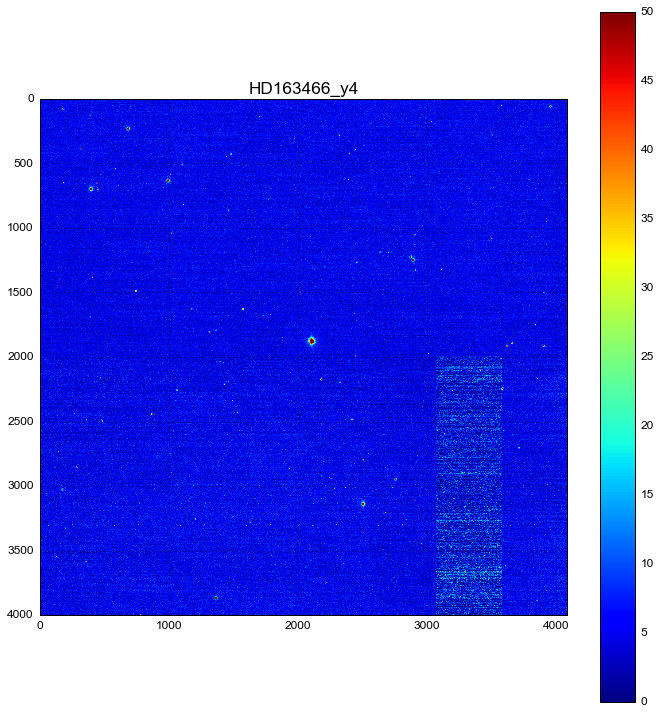

In [91]:
fig, ax = plt.subplots(figsize=(10, 10))
img=ax.imshow(ccd_chan,vmin=0,vmax=50.)
plt.title(object_name)
plt.tight_layout()
plt.colorbar(img)
#plt.savefig(outputfigfilename3)

# 6) Subtract background

code implemented from photutil information there:
https://photutils.readthedocs.io/en/latest/photutils/background.html#

In [92]:
from photutils.background import Background2D
bkg = Background2D(data, (100, 100), filter_size=(3, 3),method='median')

### does the background varies over the field of view ?

In [93]:
print('median background = ',bkg.background_median)
print('median rms = ',bkg.background_rms_median)

('median background = ', 1.7458089281766767)
('median rms = ', 0.79308761567989872)


### Radiography of the residual background

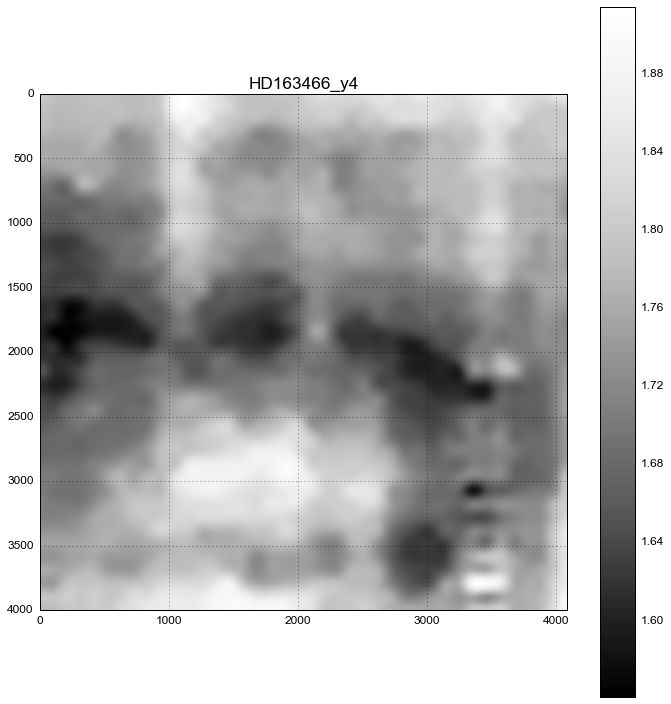

In [94]:
fig, ax = plt.subplots(figsize=(10, 10))
#plt.imshow(bkg.background, origin='lower', cmap='Greys_r')
img=ax.imshow(bkg.background, cmap='Greys_r')
plt.title(object_name)
plt.tight_layout()
plt.colorbar(img)

### Now subtract residual the background

In [95]:
data2=data - bkg.background

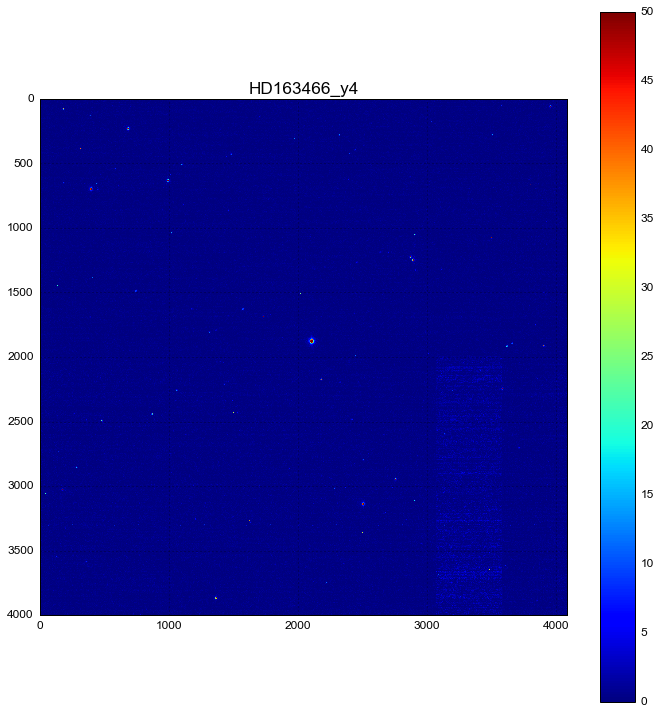

In [96]:
fig, ax = plt.subplots(figsize=(10, 10))
#plt.imshow(bkg.background, origin='lower', cmap='Greys_r')
img=plt.imshow(data2, vmin=0,vmax=50.)
#img=plt.imshow(data2)
plt.title(object_name)
plt.tight_layout()
plt.colorbar(img)

## Crop the star

In [97]:
wpix=200

In [98]:
(y0,x0)=np.where(data2==data2.max())

In [99]:
the_star2D=data2[y0-wpix:y0+wpix,x0-wpix:x0+wpix]

/Users/dagoret-campagnesylvie/anaconda/envs/pyastrophys/lib/python2.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  if __name__ == '__main__':


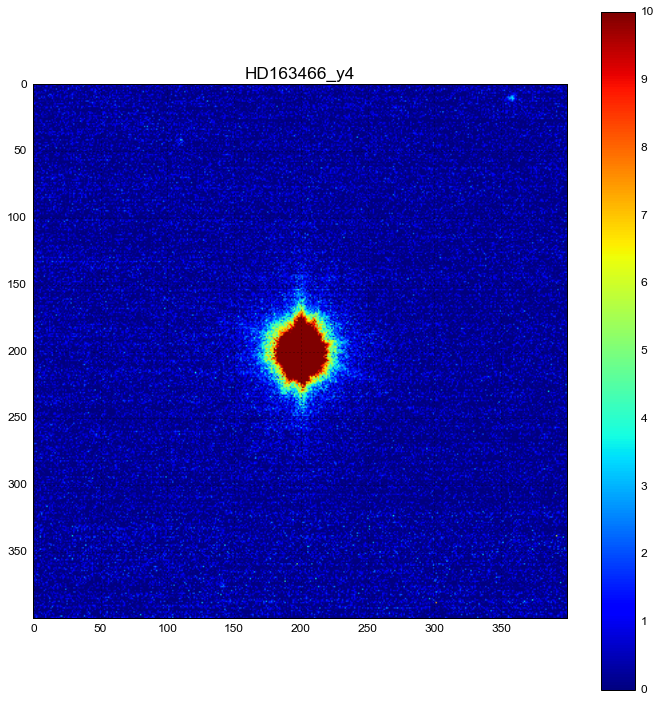

In [100]:
fig, ax = plt.subplots(figsize=(10, 10))
#plt.imshow(bkg.background, origin='lower', cmap='Greys_r')
img=plt.imshow(the_star2D, vmin=0,vmax=10.)
#img=plt.imshow(data2)
plt.title(object_name)
plt.tight_layout()
plt.colorbar(img)

## 8.) Compute signal and noise

In [101]:
mean, median, std = sigma_clipped_stats(the_star2D, sigma=10.0, iters=5)    
print(mean, median, std)    

(0.10936060878986108, 0.039405956048531476, 1.0165099355701872)


In [102]:
sources = daofind(the_star2D - median, fwhm=3.0, threshold=50.*std)
sources.sort('flux')
print(sources)   

 id   xcentroid     ycentroid   ...      peak         flux          mag      
--- ------------- ------------- ... ------------- ------------ --------------
  1 199.929492511 199.980330437 ... 10111.6681077 101.85628229 -5.01996955142


In [103]:
sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,199.929492511,199.980330437,0.431488748328,-0.344718010883,-0.0866704032542,25.0,0.0,10111.6681077,101.85628229,-5.01996955142


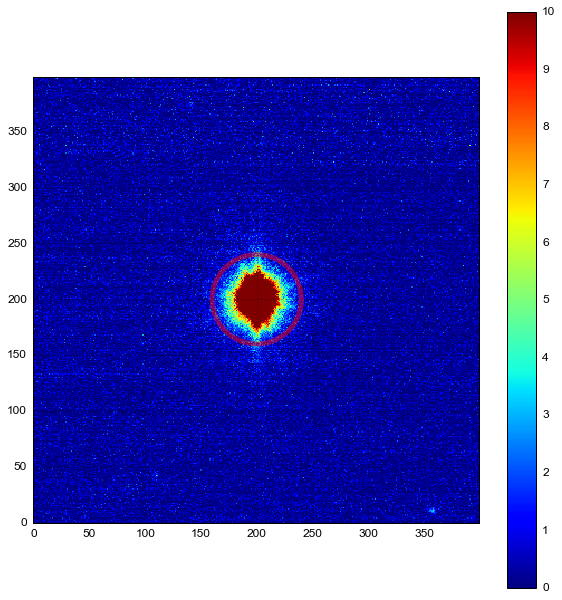

In [104]:
fig, ax = plt.subplots(figsize=(10, 10))
positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=40.)
norm = ImageNormalize(stretch=SqrtStretch())
im=ax.imshow(the_star2D,vmin=0,vmax=10.,origin='lower',interpolation='None')
#ax.imshow(data, cmap='Greys', origin='lower', norm=norm)
apertures.plot(color='red', lw=5., alpha=0.5)
plt.colorbar(im)

## The PSF

In [105]:
thePSF_2D=the_star2D

In [106]:
thepsfX=the_star2D.sum(axis=0)
thepsfY=the_star2D.sum(axis=1)

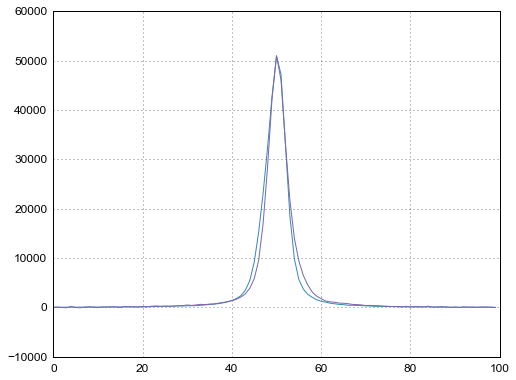

In [107]:
plt.plot(thepsfX[150:250])
plt.plot(thepsfY[150:250])

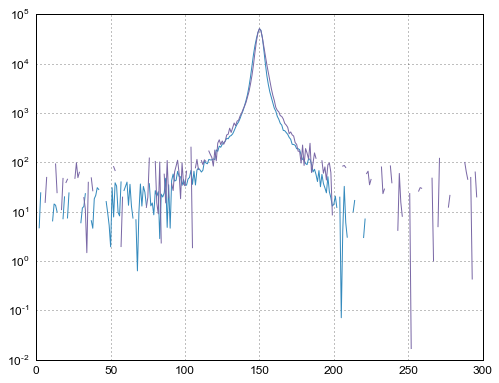

In [108]:
plt.semilogy(thepsfX[50:350])
plt.semilogy(thepsfY[50:350])

In [109]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    weights=np.where(weights>0,weights,0)
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)  # Fast and numerically precise
    return (average, np.sqrt(variance))

In [110]:
np.average(np.arange(thepsfX.shape[0]),weights=thepsfX)

198.46169760307143

In [111]:
(mx,sigx)=weighted_avg_and_std(np.arange(thepsfX.shape[0]),thepsfX)

In [112]:
(my,sigy)=weighted_avg_and_std(np.arange(thepsfY.shape[0]),thepsfY)

In [113]:
print 'sigx = ',sigx

sigx =  10.4658929282


In [114]:
print 'sigy = ',sigy

sigy =  19.2605276496


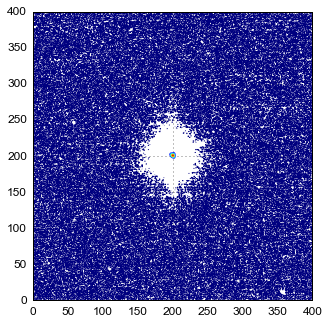

In [115]:
plt.figure(figsize=(5,5))
#onepsf2 = onepsf / np.linalg.norm(onepsf, axis=-1)[:, np.newaxis]
onepsf2 = thePSF_2D / np.sum(thePSF_2D)
levels=np.array([1,10.,100.,1000.,10000.,100000.])
#plt.contour(onepsf2,levels=levels) 
plt.contour(onepsf2,origin='lower')

# Photometry

In [116]:
apertures = CircularAperture([my,mx], r=3*max([sigx,sigy]))

In [117]:
phot_table = aperture_photometry(the_star2D, apertures)

In [118]:
print(phot_table)

 aperture_sum  xcenter [1]   ycenter [1] 
                                         
------------- ------------- -------------
331132.031009 200.467413433 199.214043518


In [119]:
sigmapix=max([sigx,sigy])
position=[my,mx]

In [120]:
#aperture_names=['ap_1sig','ap_2sig','ap_3sig','ap_4sig','ap_5sig','ap_10sig']
radii = np.array([sigmapix,2*sigmapix,3*sigmapix,4*sigmapix,5*sigmapix,10*sigmapix])
flux = []

In [121]:
for radius in radii:
    flux.append(aperture_photometry(the_star2D, CircularAperture(positions, radius)))

In [122]:
from astropy.table import hstack

In [123]:
phot_table = hstack(flux)

In [124]:
print(phot_table['aperture_sum_1', 'aperture_sum_2', 'aperture_sum_3','aperture_sum_4', 'aperture_sum_5', 'aperture_sum_6'])   

aperture_sum_1 aperture_sum_2 aperture_sum_3 ... aperture_sum_5 aperture_sum_6
                                             ...                              
-------------- -------------- -------------- ... -------------- --------------
 314376.757674  327350.789907  331141.510943 ...  333325.467664  332034.346828


## Final choice

In [125]:
star_aperture=CircularAperture(position, 3*sigmapix)

In [126]:
rawflux_table = aperture_photometry(the_star2D, star_aperture)

In [127]:
annulus_apertures = CircularAnnulus(position, r_in=5*sigmapix, r_out=7*sigmapix)

In [128]:
bkgflux_table = aperture_photometry(the_star2D, annulus_apertures)

In [129]:
phot_table = hstack([rawflux_table, bkgflux_table], table_names=['raw', 'bkg'])

In [130]:
bkg_mean = phot_table['aperture_sum_bkg'] / annulus_apertures.area()

## Result on photometry

In [131]:
bkg_sum = bkg_mean * apertures.area()
final_sum = phot_table['aperture_sum_raw'] - bkg_sum
phot_table['residual_aperture_sum'] = final_sum
print(phot_table['residual_aperture_sum']) 

residual_aperture_sum
                     
---------------------
        331203.543016


### Background fluctuation

In [132]:
med=np.median(the_star2D)   # average background level

In [133]:
data_error_scale=np.sqrt(np.median((the_star2D-med)**2))  # RMS